# Unsupervised feature learning

In this problem you will see how unsupervised learning can help you train better models even with labeled data.

In [411]:
import numpy as np

In [412]:
image_x = 32 # width of image
image_y = 32 # height of image
patch_dim = 8 # height/width of a patch

## Setting up the environment

In [413]:
class Image(object):

    def __init__(self,data,label,patches):
        """
        Constructor
        -----------
        Takes image related data, called on image creation.
        """
        self.label = label # image label
        self.patches = patches.transpose().tolist()
        
        self.__img_data = data

    def view(self):
        """
        Function: View
        --------------
        Call function to view RGB image
        """
        from PIL import Image
        im = Image.fromarray(self.__img_data)
        im = im.resize((128,128),Image.BILINEAR)
        plt.imshow(im)
        plt.show()
        

    def get_label(self):
        """
        Function: Label
        ---------------
        Returns label of image
        """
        return self.label

    def get_patches(self):
        """
        Function: Patches
        -----------------
        Returns list of patch vectors. Each patch length patch_size
        """
        return self.patches

In [414]:
def load_helper(name,m):
    channels = 3
    patch_dim = 8
    patches_per_image = (image_x/patch_dim)*(image_y/patch_dim)

    images = np.fromfile('data/CIFAR/images_'+name+'.bin',dtype=np.uint8)
    images = images.reshape((m,image_x,image_y,channels))

    patches = np.fromfile('data/CIFAR/patches_'+name+'.bin',dtype=np.float32)
    patches = patches.reshape((patch_dim**2,-1))

    labels = np.fromfile('data/CIFAR/labels_'+name+'.bin',dtype=np.uint8)

    image_list = []
    for i in range(images.shape[0]):
        image_list.append(Image(images[i,...],labels[i],
          patches[:,int(i*patches_per_image):int((i+1)*patches_per_image)]))
    
    return image_list

In [415]:
def view_helper(patches,num):
    from PIL import Image
    
    xnum = int(np.sqrt(num))
    if xnum**2 == num:
        ynum = xnum
    else:
        ynum = xnum+1

    imDim = 50

    try:
        import matplotlib.pyplot as plt
        patches = patches-np.min(patches)
        patches = patches/np.max(patches)
        patchDim = patches.shape[0]
        image = np.zeros(((patchDim+1)*ynum+1,(patchDim+1)*xnum+1))
        for i in range(ynum):
            for j in range(xnum):
                imnum = i*xnum+j
                if imnum>=num:
                    break
                ax = plt.subplot2grid((ynum,xnum),(i,j))
                if i < 3:
                    print(i, ": ", xnum, ": ", j)
                ax.imshow(patches[:,:,i*xnum+j].squeeze(), cmap = plt.get_cmap('gray'))
                ax.axes.get_xaxis().set_visible(False)
                ax.axes.get_yaxis().set_visible(False)
                
        plt.subplots_adjust(wspace=-.5 ,hspace=0.2)
        plt.show()
        return
    except ImportError:
        pass
    
    # rescale to be [0-255]
    patches = patches-np.min(patches)
    patches = 255*patches/np.max(patches)

    newpatches = np.empty((imDim,imDim,num))

    for p in range(num):
        patch = patches[:,:,p].squeeze().copy()
        im = Image.fromarray(patch)
        im = im.resize((imDim,imDim),Image.BILINEAR)
        newpatches[:,:,p] = np.asarray(im.convert('L'))

    patches = newpatches
    image = np.zeros(((imDim+1)*ynum+1,(imDim+1)*xnum+1))

    for i in range(ynum):
        for j in range(xnum):
            imnum = i*xnum+j
            if imnum>=num:
                break
            image[i*(imDim+1)+1:i*(imDim+1)+imDim+1, \
                  j*(imDim+1)+1:j*(imDim+1)+imDim+1] \
                  = patches[:,:,imnum]
    image = Image.fromarray(image, 'L')
    image.show()

In [416]:
def pixel_features(images):
    """
    Extracts raw pixel features for all images.  Returns a 2-D array
    of size featDim x numExamples and a vector of labels.
    """
    X = [np.array(image.get_patches()).ravel() for image in images]
    X = np.vstack(X).transpose() # featdim by num samples
    # label array
    Y = np.array([image.get_label() for image in images])
    return X,Y

In [417]:
def view_patches(patches):
    """
    Function: View Patches
    ----------------------
    Pass in an array of patches (or centroids) in order to view them as
    images.
    """
    view_helper(patches.reshape(patch_dim,patch_dim,-1),patches.shape[-1])

## Loading the data

In [418]:
num_train_images = 2000
file_tag = 'train'
train_image_list = load_helper(file_tag,num_train_images)

num_test_images = 1000
file_tag = 'test'
test_image_list = load_helper(file_tag,num_test_images)

In [419]:
train_X,train_Y = pixel_features(train_image_list)
test_X,test_Y = pixel_features(test_image_list)

In [420]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((1024, 2000), (2000,), (1024, 1000), (1000,))

In [421]:
test_X.shape, test_Y.shape

((1024, 1000), (1000,))

In [422]:
type(test_X[1])

numpy.ndarray

## Training logistic regression

Train logistic regression on the raw pixel data and report the train and test set results.

In [423]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import svm
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [424]:
train_X = preprocessing.scale(train_X)
logreg = LogisticRegression(max_iter=1000).fit(train_X.T, train_Y)

test_X = preprocessing.scale(test_X)
pred_X = logreg.predict(test_X.T);

In [425]:
log_acc = accuracy_score(test_Y, pred_X)
print("Accuracy of the Logistic Regression = ", log_acc)

Accuracy of the Logistic Regression =  0.535


## Training SVM

Train SVM on the raw pixel data and report the train and test set results.

In [426]:
from sklearn.preprocessing import StandardScaler

st_sc = StandardScaler()
st_sc.fit_transform(train_X)
suppvm = svm.SVC(max_iter=50).fit(train_X.T, train_Y)
pred_X = suppvm.predict(test_X.T)
svm_acc = accuracy_score(test_Y, pred_X)

print("Accuracy of the Support Vector Machine Classifier = ", svm_acc)

Accuracy of the Support Vector Machine Classifier =  0.55


/Users/sofiapetryshyn/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## Training XGBoost

Train XGBoost on the raw pixel data and report the train and test set results.

In [582]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_X.T, label=train_Y)
dtest = xgb.DMatrix(test_X.T, label=test_Y)

# xgb_classifier = XGBClassifier()

param = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 2
}
epochs = 10

model = xgb.train(param, dtrain, epochs)

In [583]:
pred_X = model.predict(dtest)

In [584]:
xgb_acc = accuracy_score(test_Y, pred_X)

print("Accuracy of the XGBoost = ", xgb_acc)

Accuracy of the XGBoost =  0.651


## Learning better features

Instead of hand-designing better features let us see if we can learn them directly from data. Each image is a 32x32 grid of pixels. We will divide the image into sixteen 8x8 "patches". Next, we will use K-means to cluster all the patches into centroids. These centroids will then allow us to use a better feature representation of the image.

Let us see how we can get patches from the images and visualize them. Make sure you understand the dimensions of every array and what they mean.

In [524]:
num_images = 2000
patches = np.hstack([np.array(image.get_patches()).transpose() for image in train_image_list[:num_images]]).T

One patch is 8 horizontal values and 8 vertical values inlined. 

In [525]:
patches.shape

(32000, 64)

In [526]:
len(patches)

32000

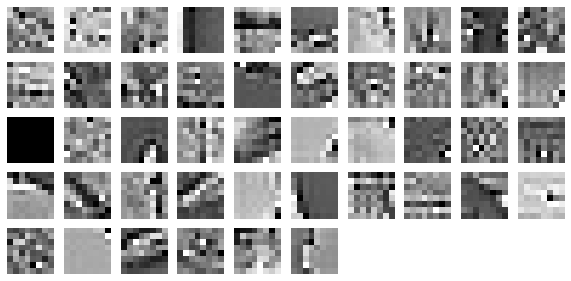

In [527]:
patch_size = (8, 8)

# visualize a random set of patches
fig = plt.figure(figsize=(10, 10))
ctr = 0
for i in range(0, len(patches), 700):
    ax=fig.add_subplot(10, 10, ctr + 1)    
    ax.axis('off')
    ax.imshow(patches[i].reshape(patch_size), cmap='gray')
    ctr+=1
    if ctr >= len(patches):
        break
plt.show();

In [528]:
from sklearn.cluster import KMeans

k_means_pca = KMeans(n_clusters=10, n_init=3, max_iter=300)
k_means_pca.fit(patches)

KMeans(n_clusters=10, n_init=3)

In [529]:
centroids = k_means_pca.cluster_centers_ # Please use this variable name for the array of centroids
# the limit is i < 3, not to have a lot of data printed
# view_patches(centroids)

## Representing examples in a new way

Now, you have the centroids defining similar groups in your patches. Represent every image in your training and test set in distances between the patch and each centroid. For example, if you used 10 clusters and each image has 16 patches, new representation of the image will be a vector of 160 elements.

In [530]:
pred_kmeans = k_means_pca.predict(patches)
pred_kmeans

array([1, 7, 2, ..., 6, 3, 0], dtype=int32)

In [531]:
pred_kmeans[0]

1

In [532]:
len(patches)

32000

In [548]:
# patches[0:16] - one image
# from scipy.spatial.distance import cdist

all_imgs = []
old, num_img = 0, 0
for new in range(16, len(patches) + 1, 16):
    img_distances = []
    img = patches[old:new]
    for patch in img:
        for claster in range(0, 10):
            centroid_patch = centroids[claster]
            patches_dist = np.linalg.norm(patch - centroid_patch)
            img_distances.append(patches_dist)
    all_imgs.append(np.asarray(img_distances))
    old += 16
    
all_imgs = np.asarray(all_imgs)
#     print(all_imgs)

In [534]:
type(all_imgs)

numpy.ndarray

In [535]:
len(all_imgs[0])

160

In [536]:
len(all_imgs)

1999

In [541]:
np.asarray(all_imgs)

array([[12.21419704, 11.92722027, 12.13928219, ...,  8.40404954,
         8.76223975,  8.34372569],
       [ 3.99916358,  4.42354106,  4.99836123, ...,  7.02295472,
         5.25054544,  6.66201204],
       [ 7.54189025,  7.22693811,  7.09985326, ...,  7.74094477,
         7.55859944,  7.0047128 ],
       ...,
       [ 5.94047073,  5.84646049,  5.94265366, ..., 12.23520422,
        12.24760276, 11.99467842],
       [ 7.34689785,  7.0710942 ,  7.40462829, ...,  8.32574922,
         8.39610636,  7.94458284],
       [ 2.25600639,  1.76883209,  1.85880887, ...,  5.70596249,
         5.57099078,  4.87042639]])

In [559]:
num_images = 1000
patches_test = np.hstack([np.array(image.get_patches()).transpose() for image in test_image_list[:num_images]]).T

all_test_imgs = []
old, num_img = 0, 0
for new in range(16, len(patches_test) + 1, 16):
    img_distances = []
    img = patches[old:new]
    for patch in img:
        for claster in range(0, 10):
            centroid_patch = centroids[claster]
            patches_dist = np.linalg.norm(patch - centroid_patch)
            img_distances.append(patches_dist)
    all_test_imgs.append(np.asarray(img_distances))
    old += 16
    
all_test_imgs = np.asarray(all_test_imgs)

In [560]:
all_test_imgs.shape, all_imgs.shape

((1000, 160), (2000, 160))

In [561]:
test_Y.shape, train_Y.shape

((1000,), (2000,))

In [562]:
type(train_Y)

numpy.ndarray

## Training classifiers

Train all three classifiers from the above (logistic regression, SVM and XGBoost) on the new image representation. Report the train and test set results.

### Logistic Regression

In [564]:
all_imgs = preprocessing.scale(all_imgs)
logreg_dist = LogisticRegression(max_iter=1000).fit(all_imgs, train_Y)

all_test_imgs = preprocessing.scale(all_test_imgs)
pred_X_dist = logreg_dist.predict(all_test_imgs)

In [565]:
log_acc_dist = accuracy_score(test_Y, pred_X_dist)
print("Accuracy of the Logistic Regression on Compressed Data = ", log_acc_dist)

Accuracy of the Logistic Regression on Compressed Data =  0.518


### SVM

In [568]:
st_sc.fit_transform(all_imgs)
suppvm_d = svm.SVC(max_iter=1000).fit(all_imgs, train_Y)
pred_X = suppvm_d.predict(all_test_imgs)
svm_acc_d = accuracy_score(test_Y, pred_X)

print("Accuracy of the Support Vector Machine Classifier on Compressed Data = ", svm_acc_d)

/Users/sofiapetryshyn/opt/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Accuracy of the Support Vector Machine Classifier on Compressed Data =  0.514


### XGBoost

In [574]:
dtrain = xgb.DMatrix(train_X.T, label=train_Y)
dtest = xgb.DMatrix(test_X.T, label=test_Y)

# xgb_classifier = XGBClassifier()

param = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 2
}
epochs = 10

model = xgb.train(param, dtrain, epochs)

pred_X = model.predict(dtest)

xgb_acc_d = accuracy_score(test_Y, pred_X)

print("Accuracy of the XGBoost on Compressed Data = ", xgb_acc_d)

Accuracy of the XGBoost =  0.651


In [575]:
print("Logistic Regression: ", log_acc,"\t\t\t SVM: ",  svm_acc, "\t\t\t XGBoost", xgb_acc)
print("*"* 100)
print("Logistic Regression: ", log_acc_dist,"\t\t\t SVM: ",  svm_acc_d, "\t\t\t XGBoost", xgb_acc_d)

Logistic Regression:  0.535 			 SVM:  0.55 			 XGBoost 0.625
****************************************************************************************************
Logistic Regression:  0.518 			 SVM:  0.514 			 XGBoost 0.651


## Getting the best out of it

In industry, we typically try to get as much as possible out of the data we have. Try different number of clusters and different configuration of the models and report the best accuracy you got on the test set.

### Conclussion:
Definitely, the best model is XGBoost, that is because we use gradient boosted trees algorithm, we can set particular paramethers to evaluate model better. When Logistic Regression and SVM are simplier classifiers.